# Tree and SVM Fidelity
This notebook highlights the fidelity between a tree ensemble and SVM under different hyperparameters.

In [26]:
import argparse

import tqdm
import sexee
import matplotlib.pyplot as plt

from util import model_util, data_util

# TODO: data import issues, should fix
import os
os.chdir('../..')

Define the values to test over for different hyperparameters:

In [27]:
def _get_values(variable='C'):

    if variable == 'C':
        result = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
    else:
        exit('{} not recorgnized'.format(variable))

    return result


def _get_explainer(model, X_train, y_train, encoding, random_state, val, variable='C'):

    if variable == 'C':
        result = sexee.TreeExplainer(model, X_train, y_train, encoding=encoding, random_state=random_state, C=val)
    else:
        exit('{} not recorgnized'.format(variable))

    return result

Train a tree ensemble, then train an SVM on the extracted feature representations and test the SVM's fidelity to the tree ensemble.

In [28]:
def fidelity(variable='C', model='lgb', encoding='tree_path', dataset='iris', n_estimators=100,
             random_state=69, timeit=False):

    # get model and data
    clf = model_util.get_classifier(model, n_estimators=n_estimators, random_state=random_state)
    X_train, X_test, y_train, y_test, label = data_util.get_data(dataset, random_state=random_state)

    # train a tree ensemble
    tree = clf.fit(X_train, y_train)
    yhat_tree_train = tree.predict(X_train)
    yhat_tree_test = tree.predict(X_test)

    # get values to test over
    vals = _get_values(variable=variable)

    # compute change in fidelity by changing the hyperparameter
    train_overlaps = []
    test_overlaps = []

    for val in tqdm.tqdm(vals):
        exp = _get_explainer(tree, X_train, y_train, encoding, random_state, val, variable=variable)
        train_feature = exp.extractor_.transform(X_train)
        test_feature = exp.extractor_.transform(X_test)

        svm = exp.get_svm()
        yhat_svm_train = svm.predict(train_feature)
        yhat_svm_test = svm.predict(test_feature)

        train_overlaps.append(model_util.fidelity(yhat_tree_train, yhat_svm_train))
        test_overlaps.append(model_util.fidelity(yhat_tree_test, yhat_svm_test))

    # convert overlaps to percentages
    train_overlap_pct = [len(overlaps) / len(y_train) for overlaps in train_overlaps]
    test_overlap_pct = [len(overlaps) / len(y_test) for overlaps in test_overlaps]

    fig, ax = plt.subplots()
    ax.plot(vals, train_overlap_pct, marker='.', label='train')
    ax.plot(vals, test_overlap_pct, marker='.', label='test')
    ax.set_xscale('log')
    ax.set_xlabel(variable)
    ax.set_ylabel('tree-svm prediction overlap (%)')
    ax.set_title('SVM Fidelity ({}, {}, {})'.format(model, encoding, dataset))
    ax.legend()
    plt.show()

## Iris

100%|██████████| 8/8 [00:02<00:00,  2.68it/s]


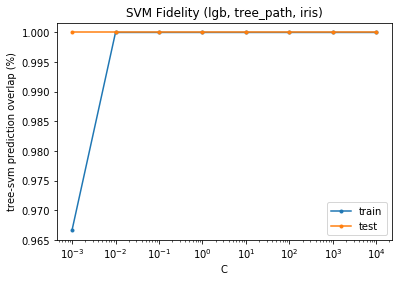

In [17]:
fidelity(variable='C', model='lgb', encoding='tree_path', dataset='iris')

100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


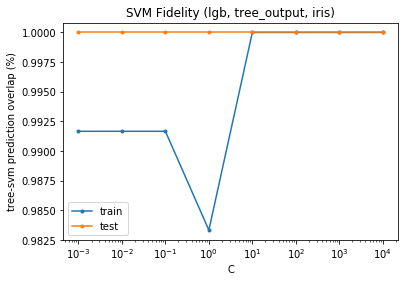

In [18]:
fidelity(variable='C', model='lgb', encoding='tree_output', dataset='iris')

## Medifor

/Users/Jonny/Documents/research/interpretability/classification/trees


100%|██████████| 7/7 [01:05<00:00,  9.25s/it]


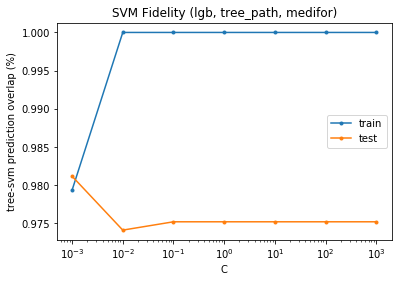

In [29]:
fidelity(variable='C', model='lgb', encoding='tree_path', dataset='medifor')

100%|██████████| 7/7 [01:22<00:00, 11.54s/it]


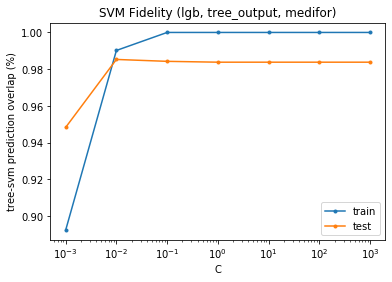

In [30]:
fidelity(variable='C', model='lgb', encoding='tree_output', dataset='medifor')

## Amazon

100%|██████████| 7/7 [02:48<00:00, 22.42s/it]


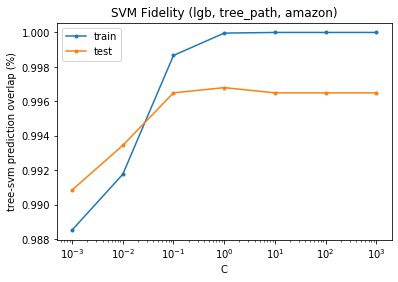

In [31]:
fidelity(variable='C', model='lgb', encoding='tree_path', dataset='amazon')

100%|██████████| 7/7 [03:01<00:00, 25.23s/it]


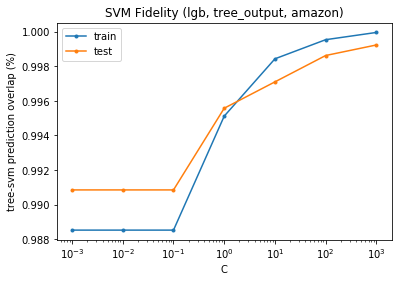

In [32]:
fidelity(variable='C', model='lgb', encoding='tree_output', dataset='amazon')